## 重采样之后的数据位置
CT： /mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/resampled_nifti/{center}/{PID}/CT.nii.gz   
PET： /mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/resampled_nifti/{center}/{PID}/PET.nii.gz  
lung mask:  /mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/lung_seg/{center}/{PID}/lung_seg.nii.gz  
lesion mask:  /mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/lesion_seg/{center}/{PID}/lesion_seg.nii.gz  

In [2]:
# 分析lung mask的bounding box尺寸分布
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

def get_bounding_box_size(mask_data):
    """
    计算非零区域的bounding box尺寸
    
    Parameters:
    mask_data: 3D numpy array, mask数据
    
    Returns:
    tuple: (width, height, depth) bounding box的尺寸
    """
    # 找到非零像素的坐标
    coords = np.where(mask_data > 0)
    
    if len(coords[0]) == 0:
        # 如果没有非零像素，返回(0,0,0)
        return (0, 0, 0)
    
    # 计算每个维度的最小和最大坐标
    min_coords = [np.min(coord) for coord in coords]
    max_coords = [np.max(coord) for coord in coords]
    
    # 计算bounding box的尺寸
    bbox_size = tuple(max_coords[i] - min_coords[i] + 1 for i in range(3))
    
    return bbox_size

def analyze_lung_mask_shapes():
    """
    分析所有lung mask的bounding box尺寸分布
    """
    print("=== 分析Lung Mask的Bounding Box尺寸分布 ===")
    
    # 读取筛选后的metadata
    metadata_df = pd.read_csv("metadata/metadata_filtered.csv", dtype={'PID': str})
    
    print(f"需要分析的样本数: {len(metadata_df)}")
    
    # 存储分析结果
    bbox_analysis_data = []
    
    print(f"\n=== 开始分析每个样本的lung mask ===")
    
    for idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="分析lung mask"):
        center = row['center']
        pid = row['PID']
        
        # 构建lung mask文件路径
        lung_mask_path = f"/mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/lung_seg/{center}/{pid}/lung_seg.nii.gz"
        
        try:
            # 加载lung mask
            nii_img = nib.load(lung_mask_path)
            mask_data = nii_img.get_fdata()
            
            # 获取原始shape
            original_shape = mask_data.shape
            
            # 计算bounding box尺寸
            bbox_size = get_bounding_box_size(mask_data)
            
            # 计算非零像素数量
            nonzero_count = np.count_nonzero(mask_data)
            
            # 记录数据
            bbox_analysis_data.append({
                'center': center,
                'PID': pid,
                'original_shape': list(original_shape),
                'bbox_size': list(bbox_size),
                'bbox_width': bbox_size[0],
                'bbox_height': bbox_size[1], 
                'bbox_depth': bbox_size[2],
                'nonzero_voxels': nonzero_count,
                'lung_mask_path': lung_mask_path
            })
            
        except Exception as e:
            print(f"\n警告: 无法处理样本 {center}/{pid}: {e}")
            bbox_analysis_data.append({
                'center': center,
                'PID': pid,
                'original_shape': None,
                'bbox_size': None,
                'bbox_width': None,
                'bbox_height': None,
                'bbox_depth': None,
                'nonzero_voxels': None,
                'lung_mask_path': lung_mask_path
            })
    
    # 转换为DataFrame
    bbox_df = pd.DataFrame(bbox_analysis_data)
    
    # 保存结果
    output_path = "metadata/lung_mask_bbox_analysis.csv"
    bbox_df.to_csv(output_path, index=False)
    print(f"\n✓ 分析结果已保存: {output_path}")
    
    return bbox_df

# 执行分析
bbox_analysis_df = analyze_lung_mask_shapes()

=== 分析Lung Mask的Bounding Box尺寸分布 ===
需要分析的样本数: 1030

=== 开始分析每个样本的lung mask ===


分析lung mask:   0%|          | 1/1030 [00:00<04:12,  4.07it/s]

分析lung mask: 100%|██████████| 1030/1030 [02:03<00:00,  8.36it/s]


✓ 分析结果已保存: metadata/lung_mask_bbox_analysis.csv


=== Lung Mask Bounding Box统计结果 ===
有效样本数: 1030 / 1030

=== 基本统计信息 ===

WIDTH 维度:
  最小值: 37
  最大值: 86
  均值: 63.56
  中位数: 63.00
  标准差: 5.84
  25%分位数: 60.00
  75%分位数: 67.00

HEIGHT 维度:
  最小值: 32
  最大值: 80
  均值: 46.55
  中位数: 46.00
  标准差: 5.42
  25%分位数: 43.00
  75%分位数: 50.00

DEPTH 维度:
  最小值: 55
  最大值: 117
  均值: 81.34
  中位数: 81.00
  标准差: 8.52
  25%分位数: 75.00
  75%分位数: 87.00

=== 各中心统计 ===

AKH_nifti_637 (618 样本):
  WIDTH: 65.0±6.0 (范围: 39-86)
  HEIGHT: 47.2±6.0 (范围: 33-80)
  DEPTH: 81.5±8.4 (范围: 58-113)

Neimeng_nifti_425 (412 样本):
  WIDTH: 61.5±4.9 (范围: 37-73)
  HEIGHT: 45.5±4.2 (范围: 32-57)
  DEPTH: 81.1±8.7 (范围: 55-117)

=== 绘制分布图 ===


/tmp/ipykernel_728428/818493838.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(center_data, labels=center_labels, patch_artist=True)
/tmp/ipykernel_728428/818493838.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(center_data, labels=center_labels, patch_artist=True)
/tmp/ipykernel_728428/818493838.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(center_data, labels=center_labels, patch_artist=True)


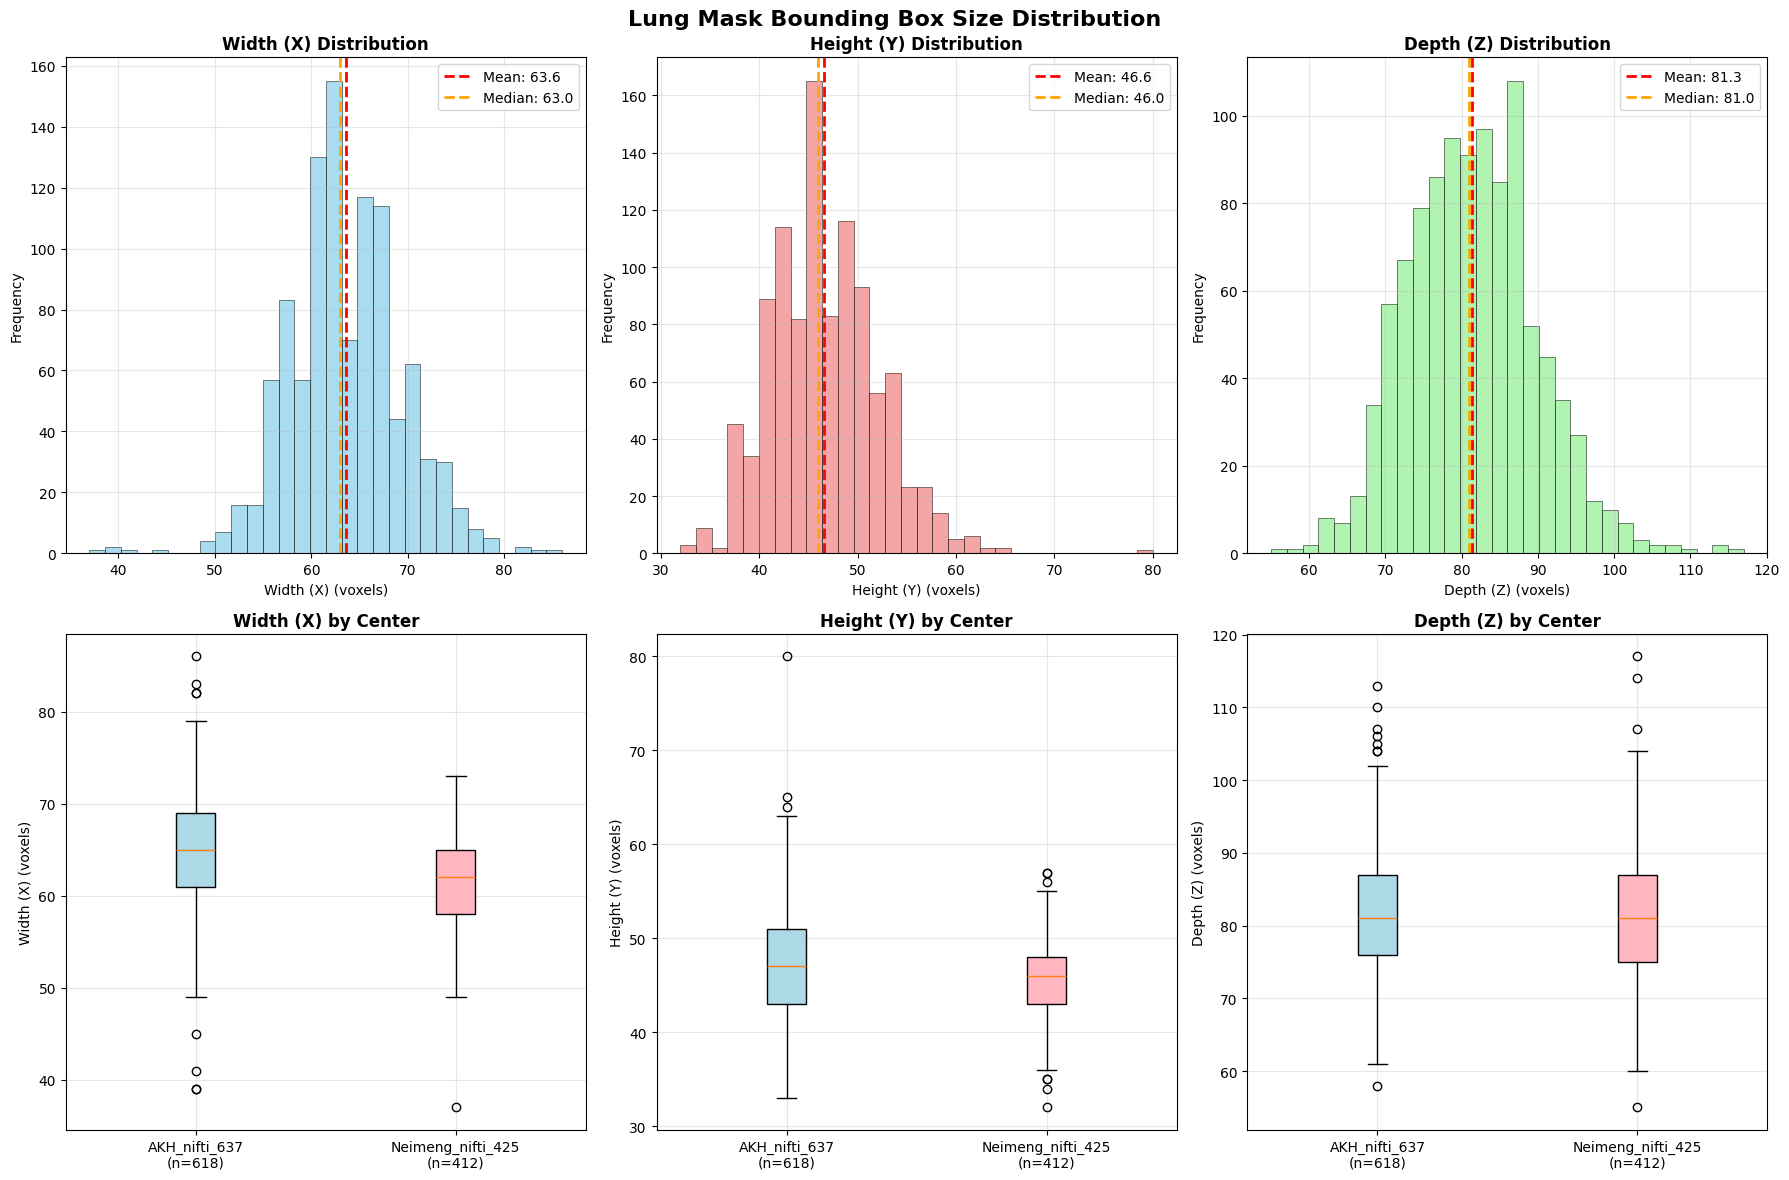


=== 绘制维度间相关性 ===


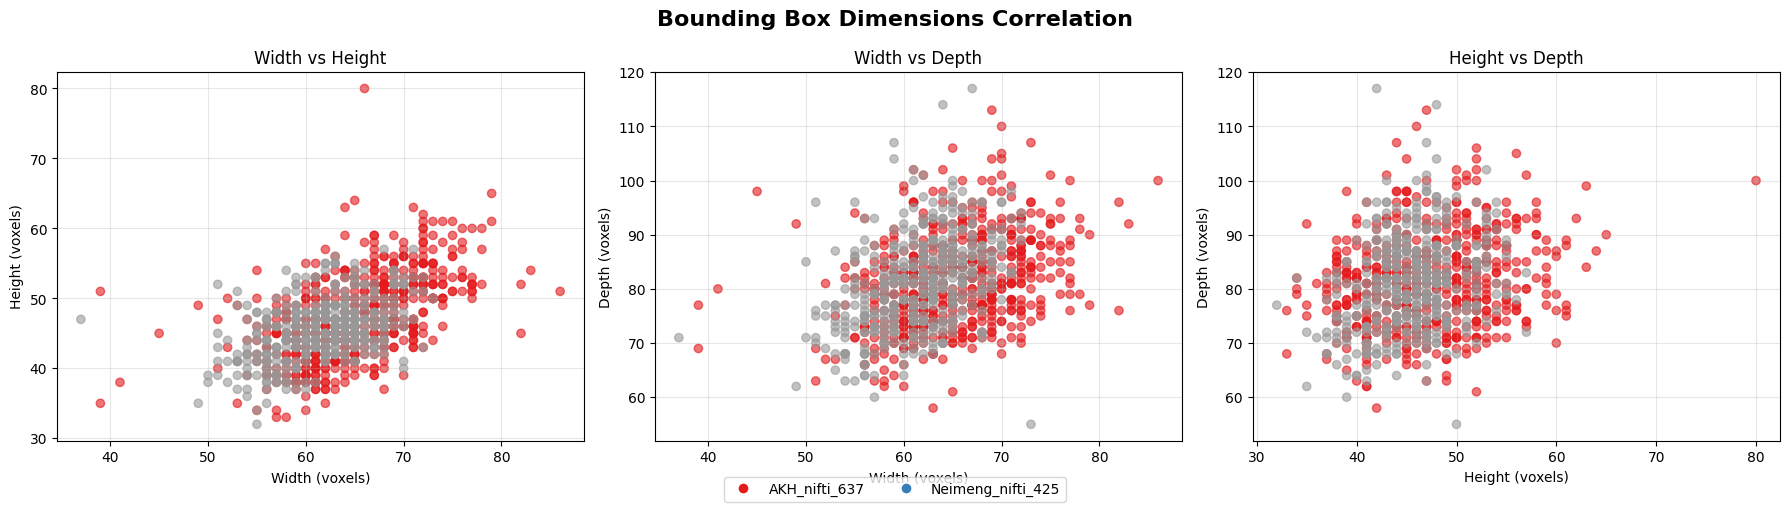

In [3]:
# 显示统计结果和绘制直方图
def display_bbox_statistics_and_plots(bbox_df):
    """
    显示bounding box统计结果并绘制分布图
    """
    print("=== Lung Mask Bounding Box统计结果 ===")
    
    # 过滤有效数据（排除None值）
    valid_df = bbox_df.dropna(subset=['bbox_width', 'bbox_height', 'bbox_depth'])
    
    print(f"有效样本数: {len(valid_df)} / {len(bbox_df)}")
    
    if len(valid_df) == 0:
        print("❌ 没有有效的bounding box数据")
        return
    
    # 基本统计
    print(f"\n=== 基本统计信息 ===")
    dimensions = ['bbox_width', 'bbox_height', 'bbox_depth']
    
    for dim in dimensions:
        data = valid_df[dim]
        print(f"\n{dim.replace('bbox_', '').upper()} 维度:")
        print(f"  最小值: {data.min()}")
        print(f"  最大值: {data.max()}")
        print(f"  均值: {data.mean():.2f}")
        print(f"  中位数: {data.median():.2f}")
        print(f"  标准差: {data.std():.2f}")
        print(f"  25%分位数: {data.quantile(0.25):.2f}")
        print(f"  75%分位数: {data.quantile(0.75):.2f}")
    
    # 按中心统计
    print(f"\n=== 各中心统计 ===")
    for center in valid_df['center'].unique():
        center_data = valid_df[valid_df['center'] == center]
        print(f"\n{center} ({len(center_data)} 样本):")
        for dim in dimensions:
            data = center_data[dim]
            print(f"  {dim.replace('bbox_', '').upper()}: {data.mean():.1f}±{data.std():.1f} "
                  f"(范围: {data.min()}-{data.max()})")
    
    # 绘制分布图
    print(f"\n=== 绘制分布图 ===")
    
    # 设置绘图样式
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Lung Mask Bounding Box Size Distribution', fontsize=16, fontweight='bold')
    
    # 颜色设置
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    dim_names = ['Width (X)', 'Height (Y)', 'Depth (Z)']
    
    # 第一行：整体分布直方图
    for i, (dim, color, name) in enumerate(zip(dimensions, colors, dim_names)):
        ax = axes[0, i]
        data = valid_df[dim]
        
        # 绘制直方图
        ax.hist(data, bins=30, alpha=0.7, color=color, edgecolor='black', linewidth=0.5)
        
        # 添加统计线
        ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.1f}')
        ax.axvline(data.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {data.median():.1f}')
        
        ax.set_title(f'{name} Distribution', fontweight='bold')
        ax.set_xlabel(f'{name} (voxels)')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 第二行：按中心分组的箱线图
    for i, (dim, name) in enumerate(zip(dimensions, dim_names)):
        ax = axes[1, i]
        
        # 准备数据
        center_data = []
        center_labels = []
        
        for center in valid_df['center'].unique():
            center_values = valid_df[valid_df['center'] == center][dim]
            center_data.append(center_values)
            center_labels.append(f"{center}\n(n={len(center_values)})")
        
        # 绘制箱线图
        bp = ax.boxplot(center_data, labels=center_labels, patch_artist=True)
        
        # 设置颜色
        for patch, color in zip(bp['boxes'], ['lightblue', 'lightpink']):
            patch.set_facecolor(color)
        
        ax.set_title(f'{name} by Center', fontweight='bold')
        ax.set_ylabel(f'{name} (voxels)')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 绘制散点图矩阵
    print(f"\n=== 绘制维度间相关性 ===")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Bounding Box Dimensions Correlation', fontsize=16, fontweight='bold')
    
    # Width vs Height
    ax = axes[0]
    scatter = ax.scatter(valid_df['bbox_width'], valid_df['bbox_height'], 
                        c=valid_df['center'].astype('category').cat.codes, 
                        alpha=0.6, cmap='Set1')
    ax.set_xlabel('Width (voxels)')
    ax.set_ylabel('Height (voxels)')
    ax.set_title('Width vs Height')
    ax.grid(True, alpha=0.3)
    
    # Width vs Depth
    ax = axes[1]
    scatter = ax.scatter(valid_df['bbox_width'], valid_df['bbox_depth'], 
                        c=valid_df['center'].astype('category').cat.codes, 
                        alpha=0.6, cmap='Set1')
    ax.set_xlabel('Width (voxels)')
    ax.set_ylabel('Depth (voxels)')
    ax.set_title('Width vs Depth')
    ax.grid(True, alpha=0.3)
    
    # Height vs Depth
    ax = axes[2]
    scatter = ax.scatter(valid_df['bbox_height'], valid_df['bbox_depth'], 
                        c=valid_df['center'].astype('category').cat.codes, 
                        alpha=0.6, cmap='Set1')
    ax.set_xlabel('Height (voxels)')
    ax.set_ylabel('Depth (voxels)')
    ax.set_title('Height vs Depth')
    ax.grid(True, alpha=0.3)
    
    # 添加图例
    centers = valid_df['center'].unique()
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor=plt.cm.Set1(i), markersize=8, label=center)
              for i, center in enumerate(centers)]
    fig.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=len(centers))
    
    plt.tight_layout()
    plt.show()

# 显示统计结果和绘图
display_bbox_statistics_and_plots(bbox_analysis_df)

In [4]:
# ROI尺寸推荐和覆盖率分析
def recommend_roi_size(bbox_df):
    """
    基于bounding box分析推荐ROI尺寸
    """
    print("=== ROI尺寸推荐 ===")
    
    # 过滤有效数据
    valid_df = bbox_df.dropna(subset=['bbox_width', 'bbox_height', 'bbox_depth'])
    
    if len(valid_df) == 0:
        print("❌ 没有有效数据进行分析")
        return
    
    dimensions = ['bbox_width', 'bbox_height', 'bbox_depth']
    dim_names = ['Width', 'Height', 'Depth']
    
    # 计算不同百分位数的推荐尺寸
    percentiles = [90, 95, 99]
    
    print(f"\n=== 不同覆盖率的ROI尺寸推荐 ===")
    
    roi_recommendations = {}
    
    for percentile in percentiles:
        roi_size = []
        print(f"\n{percentile}%覆盖率的ROI尺寸:")
        
        for dim, name in zip(dimensions, dim_names):
            size = int(np.ceil(valid_df[dim].quantile(percentile / 100)))
            roi_size.append(size)
            print(f"  {name}: {size} voxels")
        
        roi_recommendations[f'{percentile}%'] = tuple(roi_size)
        
        # 计算实际覆盖率
        covered_samples = 0
        for _, row in valid_df.iterrows():
            if (row['bbox_width'] <= roi_size[0] and 
                row['bbox_height'] <= roi_size[1] and 
                row['bbox_depth'] <= roi_size[2]):
                covered_samples += 1
        
        actual_coverage = covered_samples / len(valid_df) * 100
        print(f"  实际覆盖率: {actual_coverage:.1f}% ({covered_samples}/{len(valid_df)} 样本)")
    
    # 分析常用的标准尺寸
    print(f"\n=== 常用标准尺寸的覆盖率分析 ===")
    
    standard_sizes = [
        (128, 128, 128),
        (144, 144, 144), 
        (160, 160, 160),
        (192, 192, 192),
        (224, 224, 224),
        (256, 256, 256)
    ]
    
    coverage_analysis = []
    
    for size in standard_sizes:
        covered_samples = 0
        for _, row in valid_df.iterrows():
            if (row['bbox_width'] <= size[0] and 
                row['bbox_height'] <= size[1] and 
                row['bbox_depth'] <= size[2]):
                covered_samples += 1
        
        coverage_rate = covered_samples / len(valid_df) * 100
        coverage_analysis.append({
            'roi_size': size,
            'coverage_rate': coverage_rate,
            'covered_samples': covered_samples,
            'total_samples': len(valid_df)
        })
        
        print(f"  {size}: {coverage_rate:.1f}% ({covered_samples}/{len(valid_df)} 样本)")
    
    # 推荐最佳ROI尺寸
    print(f"\n=== 最佳ROI尺寸推荐 ===")
    
    # 基于95%覆盖率的推荐
    recommended_size = roi_recommendations['95%']
    print(f"推荐ROI尺寸 (95%覆盖率): {recommended_size}")
    
    # 找到最接近推荐尺寸的标准尺寸
    min_diff = float('inf')
    best_standard_size = None
    
    for size in standard_sizes:
        # 计算尺寸差异（使用最大维度差异）
        diff = max(abs(size[i] - recommended_size[i]) for i in range(3))
        if diff < min_diff:
            min_diff = diff
            best_standard_size = size
    
    if best_standard_size:
        best_coverage = next(item['coverage_rate'] for item in coverage_analysis 
                           if item['roi_size'] == best_standard_size)
        print(f"最接近的标准尺寸: {best_standard_size} (覆盖率: {best_coverage:.1f}%)")
    
    # 如果标准尺寸覆盖率不够，推荐自定义尺寸
    if best_coverage < 90:
        print(f"⚠️  标准尺寸覆盖率较低，建议使用自定义尺寸: {recommended_size}")
    else:
        print(f"✅ 推荐使用标准尺寸: {best_standard_size}")
    
    # 分析需要填充的样本
    print(f"\n=== 数据处理策略 ===")
    
    # 计算需要填充的样本比例
    padding_needed = 0
    cropping_needed = 0
    
    for _, row in valid_df.iterrows():
        needs_padding = (row['bbox_width'] < recommended_size[0] or 
                        row['bbox_height'] < recommended_size[1] or 
                        row['bbox_depth'] < recommended_size[2])
        needs_cropping = (row['bbox_width'] > recommended_size[0] or 
                         row['bbox_height'] > recommended_size[1] or 
                         row['bbox_depth'] > recommended_size[2])
        
        if needs_padding:
            padding_needed += 1
        if needs_cropping:
            cropping_needed += 1
    
    print(f"需要填充的样本: {padding_needed} ({padding_needed/len(valid_df)*100:.1f}%)")
    print(f"需要裁剪的样本: {cropping_needed} ({cropping_needed/len(valid_df)*100:.1f}%)")
    
    return roi_recommendations, coverage_analysis

# 执行ROI尺寸推荐
roi_recommendations, coverage_analysis = recommend_roi_size(bbox_analysis_df)

=== ROI尺寸推荐 ===

=== 不同覆盖率的ROI尺寸推荐 ===

90%覆盖率的ROI尺寸:
  Width: 71 voxels
  Height: 53 voxels
  Depth: 92 voxels
  实际覆盖率: 77.5% (798/1030 样本)

95%覆盖率的ROI尺寸:
  Width: 73 voxels
  Height: 56 voxels
  Depth: 96 voxels
  实际覆盖率: 89.8% (925/1030 样本)

99%覆盖率的ROI尺寸:
  Width: 77 voxels
  Height: 61 voxels
  Depth: 104 voxels
  实际覆盖率: 97.9% (1008/1030 样本)

=== 常用标准尺寸的覆盖率分析 ===
  (128, 128, 128): 100.0% (1030/1030 样本)
  (144, 144, 144): 100.0% (1030/1030 样本)
  (160, 160, 160): 100.0% (1030/1030 样本)
  (192, 192, 192): 100.0% (1030/1030 样本)
  (224, 224, 224): 100.0% (1030/1030 样本)
  (256, 256, 256): 100.0% (1030/1030 样本)

=== 最佳ROI尺寸推荐 ===
推荐ROI尺寸 (95%覆盖率): (73, 56, 96)
最接近的标准尺寸: (128, 128, 128) (覆盖率: 100.0%)
✅ 推荐使用标准尺寸: (128, 128, 128)

=== 数据处理策略 ===
需要填充的样本: 1028 (99.8%)
需要裁剪的样本: 105 (10.2%)


## Lesion mask 的shape分析

In [5]:
# 分析lesion mask的bounding box尺寸分布
def analyze_lesion_mask_shapes():
    """
    分析所有lesion mask的bounding box尺寸分布
    """
    print("=== 分析Lesion Mask的Bounding Box尺寸分布 ===")
    
    # 读取筛选后的metadata
    metadata_df = pd.read_csv("metadata/metadata_filtered.csv", dtype={'PID': str})
    
    print(f"需要分析的样本数: {len(metadata_df)}")
    
    # 存储分析结果
    lesion_bbox_analysis_data = []
    
    print(f"\n=== 开始分析每个样本的lesion mask ===")
    
    for idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="分析lesion mask"):
        center = row['center']
        pid = row['PID']
        
        # 构建lesion mask文件路径
        lesion_mask_path = f"/mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/lesion_seg/{center}/{pid}/lesion_seg.nii.gz"
        
        try:
            # 加载lesion mask
            nii_img = nib.load(lesion_mask_path)
            mask_data = nii_img.get_fdata()
            
            # 获取原始shape
            original_shape = mask_data.shape
            
            # 计算bounding box尺寸
            bbox_size = get_bounding_box_size(mask_data)
            
            # 计算非零像素数量
            nonzero_count = np.count_nonzero(mask_data)
            
            # 记录数据
            lesion_bbox_analysis_data.append({
                'center': center,
                'PID': pid,
                'original_shape': list(original_shape),
                'bbox_size': list(bbox_size),
                'bbox_width': bbox_size[0],
                'bbox_height': bbox_size[1], 
                'bbox_depth': bbox_size[2],
                'nonzero_voxels': nonzero_count,
                'lesion_mask_path': lesion_mask_path
            })
            
        except Exception as e:
            print(f"\n警告: 无法处理样本 {center}/{pid}: {e}")
            lesion_bbox_analysis_data.append({
                'center': center,
                'PID': pid,
                'original_shape': None,
                'bbox_size': None,
                'bbox_width': None,
                'bbox_height': None,
                'bbox_depth': None,
                'nonzero_voxels': None,
                'lesion_mask_path': lesion_mask_path
            })
    
    # 转换为DataFrame
    lesion_bbox_df = pd.DataFrame(lesion_bbox_analysis_data)
    
    # 保存结果
    output_path = "metadata/lesion_mask_bbox_analysis.csv"
    lesion_bbox_df.to_csv(output_path, index=False)
    print(f"\n✓ 分析结果已保存: {output_path}")
    
    return lesion_bbox_df

# 执行lesion mask分析
lesion_bbox_analysis_df = analyze_lesion_mask_shapes()

=== 分析Lesion Mask的Bounding Box尺寸分布 ===
需要分析的样本数: 1030

=== 开始分析每个样本的lesion mask ===


分析lesion mask: 100%|██████████| 1030/1030 [02:01<00:00,  8.46it/s]


✓ 分析结果已保存: metadata/lesion_mask_bbox_analysis.csv


=== Lesion Mask Bounding Box统计结果 ===
有效样本数: 1030 / 1030

=== 基本统计信息 ===

WIDTH 维度:
  最小值: 9
  最大值: 55
  均值: 21.71
  中位数: 23.00
  标准差: 3.91
  25%分位数: 23.00
  75%分位数: 23.00

HEIGHT 维度:
  最小值: 9
  最大值: 35
  均值: 21.64
  中位数: 23.00
  标准差: 3.83
  25%分位数: 23.00
  75%分位数: 23.00

DEPTH 维度:
  最小值: 15
  最大值: 48
  均值: 26.73
  中位数: 23.00
  标准差: 8.42
  25%分位数: 23.00
  75%分位数: 38.00

=== 各中心统计 ===

AKH_nifti_637 (618 样本):
  WIDTH: 20.9±4.9 (范围: 9-55)
  HEIGHT: 20.8±4.8 (范围: 9-35)
  DEPTH: 21.3±3.4 (范围: 15-48)

Neimeng_nifti_425 (412 样本):
  WIDTH: 23.0±0.2 (范围: 22-23)
  HEIGHT: 22.9±0.3 (范围: 22-23)
  DEPTH: 34.8±7.2 (范围: 20-39)

=== 绘制Lesion分布图 ===


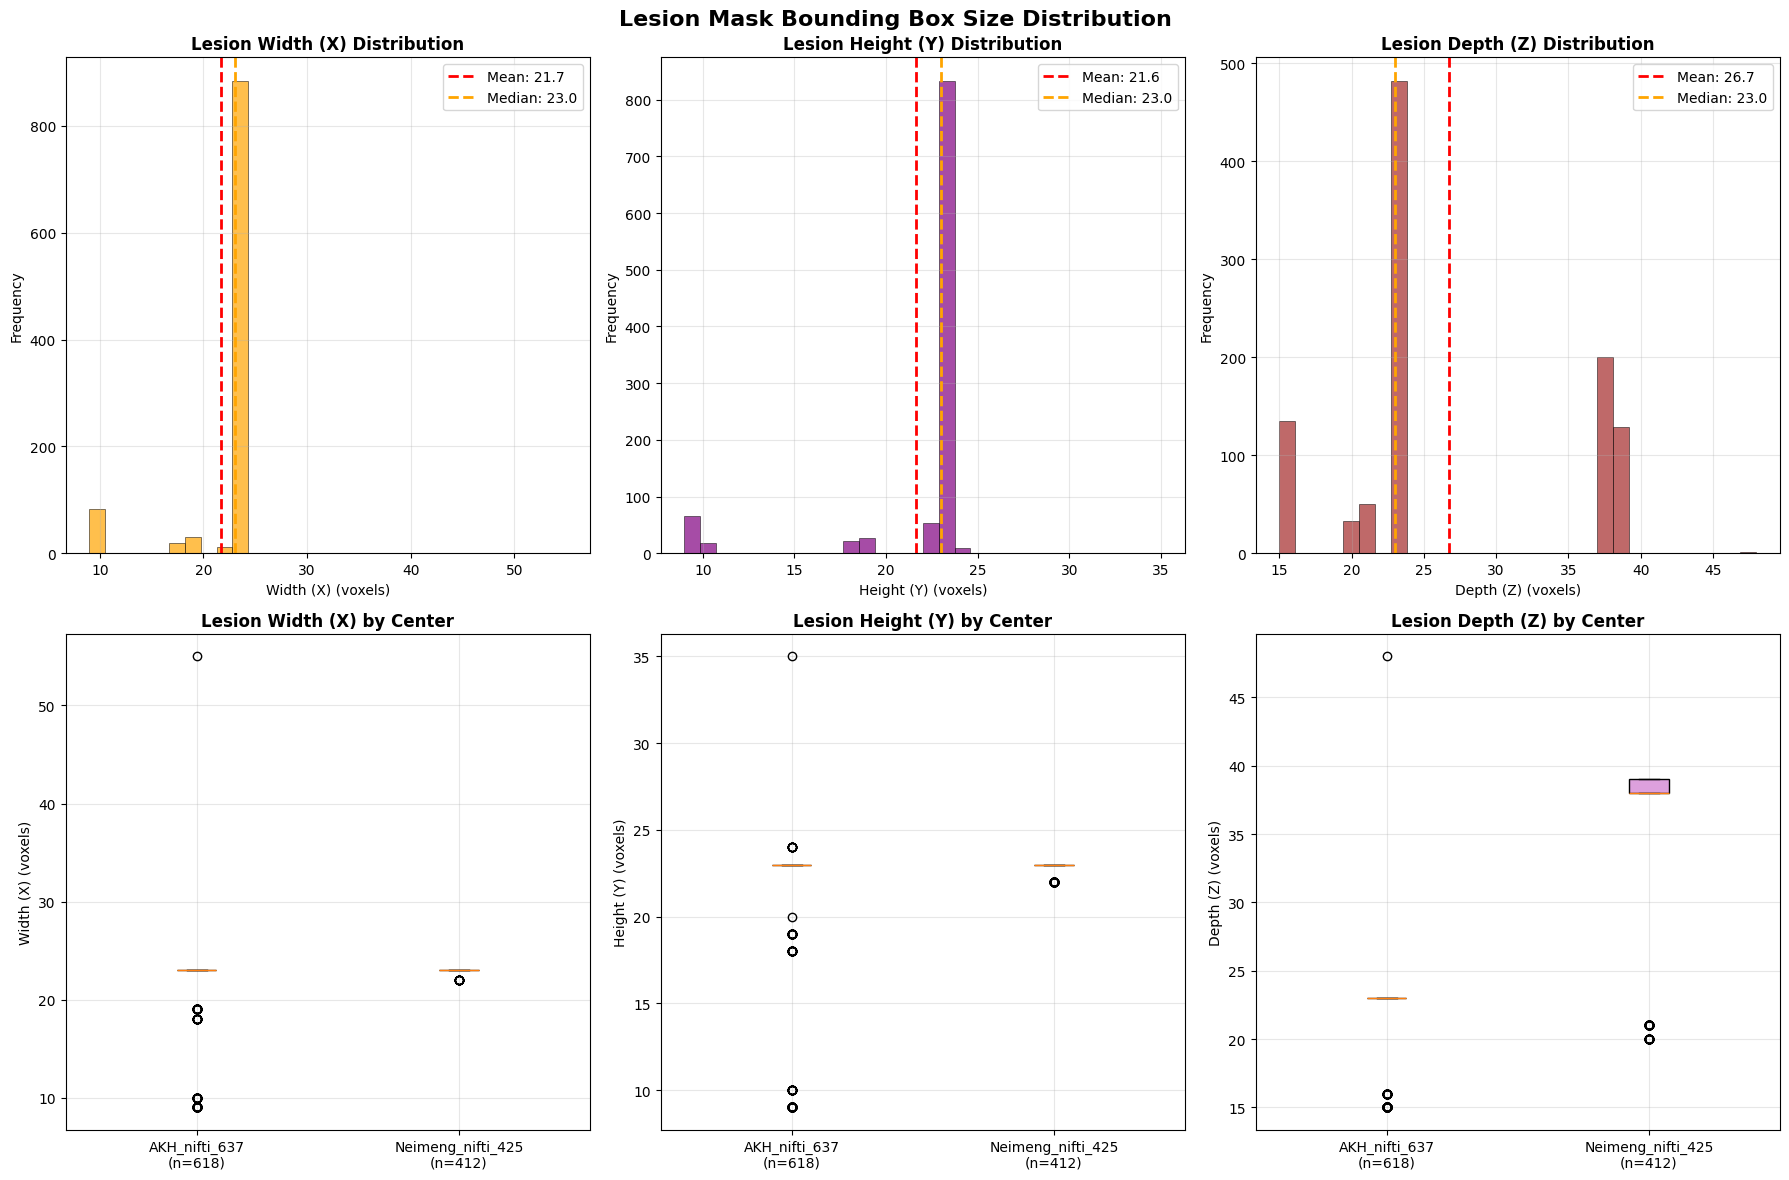


=== 绘制Lesion维度间相关性 ===


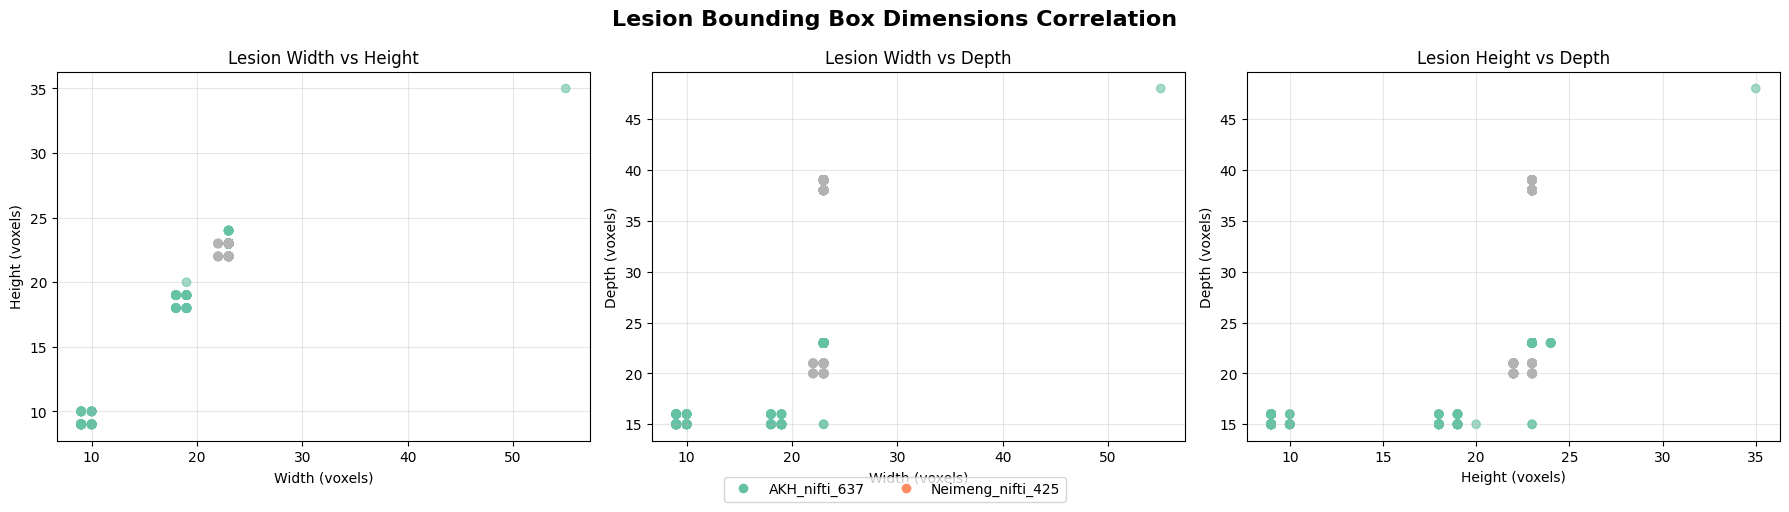

In [6]:
# 显示lesion mask统计结果和绘制直方图
def display_lesion_bbox_statistics_and_plots(lesion_bbox_df):
    """
    显示lesion bounding box统计结果并绘制分布图
    """
    print("=== Lesion Mask Bounding Box统计结果 ===")
    
    # 过滤有效数据（排除None值和空lesion）
    valid_df = lesion_bbox_df.dropna(subset=['bbox_width', 'bbox_height', 'bbox_depth'])
    # 进一步过滤掉bbox_size为(0,0,0)的情况（空lesion）
    valid_df = valid_df[
        (valid_df['bbox_width'] > 0) & 
        (valid_df['bbox_height'] > 0) & 
        (valid_df['bbox_depth'] > 0)
    ]
    
    print(f"有效样本数: {len(valid_df)} / {len(lesion_bbox_df)}")
    
    if len(valid_df) == 0:
        print("❌ 没有有效的lesion bounding box数据")
        return
    
    # 检查空lesion的情况
    empty_lesions = len(lesion_bbox_df) - len(valid_df)
    if empty_lesions > 0:
        print(f"⚠️ 发现 {empty_lesions} 个空lesion样本")
    
    # 基本统计
    print(f"\n=== 基本统计信息 ===")
    dimensions = ['bbox_width', 'bbox_height', 'bbox_depth']
    
    for dim in dimensions:
        data = valid_df[dim]
        print(f"\n{dim.replace('bbox_', '').upper()} 维度:")
        print(f"  最小值: {data.min()}")
        print(f"  最大值: {data.max()}")
        print(f"  均值: {data.mean():.2f}")
        print(f"  中位数: {data.median():.2f}")
        print(f"  标准差: {data.std():.2f}")
        print(f"  25%分位数: {data.quantile(0.25):.2f}")
        print(f"  75%分位数: {data.quantile(0.75):.2f}")
    
    # 按中心统计
    print(f"\n=== 各中心统计 ===")
    for center in valid_df['center'].unique():
        center_data = valid_df[valid_df['center'] == center]
        print(f"\n{center} ({len(center_data)} 样本):")
        for dim in dimensions:
            data = center_data[dim]
            print(f"  {dim.replace('bbox_', '').upper()}: {data.mean():.1f}±{data.std():.1f} "
                  f"(范围: {data.min()}-{data.max()})")
    
    # 绘制分布图
    print(f"\n=== 绘制Lesion分布图 ===")
    
    # 设置绘图样式
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Lesion Mask Bounding Box Size Distribution', fontsize=16, fontweight='bold')
    
    # 颜色设置
    colors = ['orange', 'purple', 'brown']
    dim_names = ['Width (X)', 'Height (Y)', 'Depth (Z)']
    
    # 第一行：整体分布直方图
    for i, (dim, color, name) in enumerate(zip(dimensions, colors, dim_names)):
        ax = axes[0, i]
        data = valid_df[dim]
        
        # 绘制直方图
        ax.hist(data, bins=30, alpha=0.7, color=color, edgecolor='black', linewidth=0.5)
        
        # 添加统计线
        ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.1f}')
        ax.axvline(data.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {data.median():.1f}')
        
        ax.set_title(f'Lesion {name} Distribution', fontweight='bold')
        ax.set_xlabel(f'{name} (voxels)')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 第二行：按中心分组的箱线图
    for i, (dim, name) in enumerate(zip(dimensions, dim_names)):
        ax = axes[1, i]
        
        # 准备数据
        center_data = []
        center_labels = []
        
        for center in valid_df['center'].unique():
            center_values = valid_df[valid_df['center'] == center][dim]
            center_data.append(center_values)
            center_labels.append(f"{center}\n(n={len(center_values)})")
        
        # 绘制箱线图
        bp = ax.boxplot(center_data, tick_labels=center_labels, patch_artist=True)
        
        # 设置颜色
        for patch, color in zip(bp['boxes'], ['lightsalmon', 'plum']):
            patch.set_facecolor(color)
        
        ax.set_title(f'Lesion {name} by Center', fontweight='bold')
        ax.set_ylabel(f'{name} (voxels)')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 绘制散点图矩阵
    print(f"\n=== 绘制Lesion维度间相关性 ===")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Lesion Bounding Box Dimensions Correlation', fontsize=16, fontweight='bold')
    
    # Width vs Height
    ax = axes[0]
    scatter = ax.scatter(valid_df['bbox_width'], valid_df['bbox_height'], 
                        c=valid_df['center'].astype('category').cat.codes, 
                        alpha=0.6, cmap='Set2')
    ax.set_xlabel('Width (voxels)')
    ax.set_ylabel('Height (voxels)')
    ax.set_title('Lesion Width vs Height')
    ax.grid(True, alpha=0.3)
    
    # Width vs Depth
    ax = axes[1]
    scatter = ax.scatter(valid_df['bbox_width'], valid_df['bbox_depth'], 
                        c=valid_df['center'].astype('category').cat.codes, 
                        alpha=0.6, cmap='Set2')
    ax.set_xlabel('Width (voxels)')
    ax.set_ylabel('Depth (voxels)')
    ax.set_title('Lesion Width vs Depth')
    ax.grid(True, alpha=0.3)
    
    # Height vs Depth
    ax = axes[2]
    scatter = ax.scatter(valid_df['bbox_height'], valid_df['bbox_depth'], 
                        c=valid_df['center'].astype('category').cat.codes, 
                        alpha=0.6, cmap='Set2')
    ax.set_xlabel('Height (voxels)')
    ax.set_ylabel('Depth (voxels)')
    ax.set_title('Lesion Height vs Depth')
    ax.grid(True, alpha=0.3)
    
    # 添加图例
    centers = valid_df['center'].unique()
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor=plt.cm.Set2(i), markersize=8, label=center)
              for i, center in enumerate(centers)]
    fig.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=len(centers))
    
    plt.tight_layout()
    plt.show()
    
    return valid_df

# 显示lesion mask统计结果和绘图
valid_lesion_df = display_lesion_bbox_statistics_and_plots(lesion_bbox_analysis_df)

In [7]:
# Lesion ROI尺寸推荐和覆盖率分析
def recommend_lesion_roi_size(valid_lesion_df):
    """
    基于lesion bounding box分析推荐ROI尺寸
    """
    print("=== Lesion ROI尺寸推荐 ===")
    
    if len(valid_lesion_df) == 0:
        print("❌ 没有有效数据进行分析")
        return
    
    dimensions = ['bbox_width', 'bbox_height', 'bbox_depth']
    dim_names = ['Width', 'Height', 'Depth']
    
    # 计算不同百分位数的推荐尺寸
    percentiles = [90, 95, 99]
    
    print(f"\n=== 不同覆盖率的Lesion ROI尺寸推荐 ===")
    
    lesion_roi_recommendations = {}
    
    for percentile in percentiles:
        roi_size = []
        print(f"\n{percentile}%覆盖率的ROI尺寸:")
        
        for dim, name in zip(dimensions, dim_names):
            size = int(np.ceil(valid_lesion_df[dim].quantile(percentile / 100)))
            roi_size.append(size)
            print(f"  {name}: {size} voxels")
        
        lesion_roi_recommendations[f'{percentile}%'] = tuple(roi_size)
        
        # 计算实际覆盖率
        covered_samples = 0
        for _, row in valid_lesion_df.iterrows():
            if (row['bbox_width'] <= roi_size[0] and 
                row['bbox_height'] <= roi_size[1] and 
                row['bbox_depth'] <= roi_size[2]):
                covered_samples += 1
        
        actual_coverage = covered_samples / len(valid_lesion_df) * 100
        print(f"  实际覆盖率: {actual_coverage:.1f}% ({covered_samples}/{len(valid_lesion_df)} 样本)")
    
    # 分析常用的标准尺寸（针对lesion较小的特点）
    print(f"\n=== 常用标准尺寸的覆盖率分析 ===")
    
    standard_sizes = [
        (32, 32, 32),
        (48, 48, 48),
        (64, 64, 64),
        (80, 80, 80),
        (96, 96, 96),
        (128, 128, 128)
    ]
    
    coverage_analysis = []
    
    for size in standard_sizes:
        covered_samples = 0
        for _, row in valid_lesion_df.iterrows():
            if (row['bbox_width'] <= size[0] and 
                row['bbox_height'] <= size[1] and 
                row['bbox_depth'] <= size[2]):
                covered_samples += 1
        
        coverage_rate = covered_samples / len(valid_lesion_df) * 100
        coverage_analysis.append({
            'roi_size': size,
            'coverage_rate': coverage_rate,
            'covered_samples': covered_samples,
            'total_samples': len(valid_lesion_df)
        })
        
        print(f"  {size}: {coverage_rate:.1f}% ({covered_samples}/{len(valid_lesion_df)} 样本)")
    
    # 推荐最佳lesion ROI尺寸
    print(f"\n=== 最佳Lesion ROI尺寸推荐 ===")
    
    # 基于95%覆盖率的推荐
    recommended_size = lesion_roi_recommendations['95%']
    print(f"推荐Lesion ROI尺寸 (95%覆盖率): {recommended_size}")
    
    # 找到最接近推荐尺寸的标准尺寸
    min_diff = float('inf')
    best_standard_size = None
    
    for size in standard_sizes:
        # 计算尺寸差异（使用最大维度差异）
        diff = max(abs(size[i] - recommended_size[i]) for i in range(3))
        if diff < min_diff:
            min_diff = diff
            best_standard_size = size
    
    if best_standard_size:
        best_coverage = next(item['coverage_rate'] for item in coverage_analysis 
                           if item['roi_size'] == best_standard_size)
        print(f"最接近的标准尺寸: {best_standard_size} (覆盖率: {best_coverage:.1f}%)")
    
    # 如果标准尺寸覆盖率不够，推荐自定义尺寸
    if best_coverage < 90:
        print(f"⚠️  标准尺寸覆盖率较低，建议使用自定义尺寸: {recommended_size}")
    else:
        print(f"✅ 推荐使用标准尺寸: {best_standard_size}")
    
    # 分析需要填充的样本
    print(f"\n=== Lesion数据处理策略 ===")
    
    # 计算需要填充的样本比例
    padding_needed = 0
    cropping_needed = 0
    
    for _, row in valid_lesion_df.iterrows():
        needs_padding = (row['bbox_width'] < recommended_size[0] or 
                        row['bbox_height'] < recommended_size[1] or 
                        row['bbox_depth'] < recommended_size[2])
        needs_cropping = (row['bbox_width'] > recommended_size[0] or 
                         row['bbox_height'] > recommended_size[1] or 
                         row['bbox_depth'] > recommended_size[2])
        
        if needs_padding:
            padding_needed += 1
        if needs_cropping:
            cropping_needed += 1
    
    print(f"需要填充的样本: {padding_needed} ({padding_needed/len(valid_lesion_df)*100:.1f}%)")
    print(f"需要裁剪的样本: {cropping_needed} ({cropping_needed/len(valid_lesion_df)*100:.1f}%)")
    
    # 比较lung和lesion ROI尺寸
    print(f"\n=== Lung vs Lesion ROI尺寸对比 ===")
    lung_recommended = (73, 56, 96)  # 从之前的分析得出
    print(f"Lung ROI推荐尺寸: {lung_recommended}")
    print(f"Lesion ROI推荐尺寸: {recommended_size}")
    print(f"尺寸比例 (Lesion/Lung): ({recommended_size[0]/lung_recommended[0]:.2f}, "
          f"{recommended_size[1]/lung_recommended[1]:.2f}, {recommended_size[2]/lung_recommended[2]:.2f})")
    
    return lesion_roi_recommendations, coverage_analysis

# 执行lesion ROI尺寸推荐
lesion_roi_recommendations, lesion_coverage_analysis = recommend_lesion_roi_size(valid_lesion_df)

=== Lesion ROI尺寸推荐 ===

=== 不同覆盖率的Lesion ROI尺寸推荐 ===

90%覆盖率的ROI尺寸:
  Width: 23 voxels
  Height: 23 voxels
  Depth: 39 voxels
  实际覆盖率: 99.0% (1020/1030 样本)

95%覆盖率的ROI尺寸:
  Width: 23 voxels
  Height: 23 voxels
  Depth: 39 voxels
  实际覆盖率: 99.0% (1020/1030 样本)

99%覆盖率的ROI尺寸:
  Width: 23 voxels
  Height: 23 voxels
  Depth: 39 voxels
  实际覆盖率: 99.0% (1020/1030 样本)

=== 常用标准尺寸的覆盖率分析 ===
  (32, 32, 32): 68.0% (700/1030 样本)
  (48, 48, 48): 99.9% (1029/1030 样本)
  (64, 64, 64): 100.0% (1030/1030 样本)
  (80, 80, 80): 100.0% (1030/1030 样本)
  (96, 96, 96): 100.0% (1030/1030 样本)
  (128, 128, 128): 100.0% (1030/1030 样本)

=== 最佳Lesion ROI尺寸推荐 ===
推荐Lesion ROI尺寸 (95%覆盖率): (23, 23, 39)
最接近的标准尺寸: (32, 32, 32) (覆盖率: 68.0%)
⚠️  标准尺寸覆盖率较低，建议使用自定义尺寸: (23, 23, 39)

=== Lesion数据处理策略 ===
需要填充的样本: 900 (87.4%)
需要裁剪的样本: 10 (1.0%)

=== Lung vs Lesion ROI尺寸对比 ===
Lung ROI推荐尺寸: (73, 56, 96)
Lesion ROI推荐尺寸: (23, 23, 39)
尺寸比例 (Lesion/Lung): (0.32, 0.41, 0.41)


## 使用 96 * 64 * 128 的ROI尺寸对CT和PET进行裁切

In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# 验证固定ROI尺寸 [96, 64, 128] 对lesion的覆盖情况
def validate_lesion_coverage_with_fixed_roi():
    """
    验证使用固定ROI尺寸 [96, 64, 128] 时，是否会裁切到lesion
    """
    print("=== 验证固定ROI尺寸对Lesion的覆盖情况 ===")
    
    # 固定的ROI尺寸 [width, height, depth]
    fixed_roi_size = [96, 64, 128]
    print(f"固定ROI尺寸: {fixed_roi_size}")
    
    # 读取筛选后的metadata
    metadata_df = pd.read_csv("metadata/metadata_filtered.csv", dtype={'PID': str})
    print(f"需要验证的样本数: {len(metadata_df)}")
    
    # 存储验证结果
    validation_results = []
    lesion_truncation_cases = []
    
    print(f"\n=== 开始验证每个样本 ===")
    
    for idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="验证lesion覆盖"):
        center = row['center']
        pid = row['PID']
        
        try:
            # 构建文件路径
            lung_mask_path = f"/mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/lung_seg/{center}/{pid}/lung_seg.nii.gz"
            lesion_mask_path = f"/mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/lesion_seg/{center}/{pid}/lesion_seg.nii.gz"
            
            # 加载lung mask
            lung_nii = nib.load(lung_mask_path)
            lung_data = lung_nii.get_fdata()
            
            # 加载lesion mask
            lesion_nii = nib.load(lesion_mask_path)
            lesion_data = lesion_nii.get_fdata()
            
            # 获取lung mask的bounding box
            lung_coords = np.where(lung_data > 0)
            if len(lung_coords[0]) == 0:
                print(f"\n警告: {center}/{pid} 的lung mask为空")
                continue
                
            lung_min_coords = [np.min(coord) for coord in lung_coords]
            lung_max_coords = [np.max(coord) for coord in lung_coords]
            lung_bbox_size = [lung_max_coords[i] - lung_min_coords[i] + 1 for i in range(3)]
            
            # 计算lung中心点
            lung_center = [(lung_min_coords[i] + lung_max_coords[i]) // 2 for i in range(3)]
            
            # 基于lung中心计算固定ROI的范围
            roi_min = [max(0, lung_center[i] - fixed_roi_size[i] // 2) for i in range(3)]
            roi_max = [min(lung_data.shape[i], roi_min[i] + fixed_roi_size[i]) for i in range(3)]
            
            # 调整roi_min以确保ROI尺寸正确
            for i in range(3):
                if roi_max[i] - roi_min[i] < fixed_roi_size[i]:
                    roi_min[i] = max(0, roi_max[i] - fixed_roi_size[i])
            
            # 获取lesion mask的bounding box
            lesion_coords = np.where(lesion_data > 0)
            lesion_coverage_status = "完全覆盖"
            lesion_bbox_size = [0, 0, 0]
            lesion_outside_roi = False
            
            if len(lesion_coords[0]) > 0:  # 如果lesion不为空
                lesion_min_coords = [np.min(coord) for coord in lesion_coords]
                lesion_max_coords = [np.max(coord) for coord in lesion_coords]
                lesion_bbox_size = [lesion_max_coords[i] - lesion_min_coords[i] + 1 for i in range(3)]
                
                # 检查lesion是否完全在ROI范围内
                lesion_in_roi = True
                for i in range(3):
                    if lesion_min_coords[i] < roi_min[i] or lesion_max_coords[i] >= roi_max[i]:
                        lesion_in_roi = False
                        lesion_outside_roi = True
                        break
                
                if not lesion_in_roi:
                    lesion_coverage_status = "部分裁切"
                    
                    # 记录被裁切的案例
                    lesion_truncation_cases.append({
                        'center': center,
                        'PID': pid,
                        'lung_bbox_size': lung_bbox_size,
                        'lesion_bbox_size': lesion_bbox_size,
                        'lung_center': lung_center,
                        'roi_range': f"[{roi_min[0]}:{roi_max[0]}, {roi_min[1]}:{roi_max[1]}, {roi_min[2]}:{roi_max[2]}]",
                        'lesion_range': f"[{lesion_min_coords[0]}:{lesion_max_coords[0]}, {lesion_min_coords[1]}:{lesion_max_coords[1]}, {lesion_min_coords[2]}:{lesion_max_coords[2]}]",
                        'lung_mask_path': lung_mask_path,
                        'lesion_mask_path': lesion_mask_path
                    })
            else:
                lesion_coverage_status = "空lesion"
            
            # 记录验证结果
            validation_results.append({
                'center': center,
                'PID': pid,
                'lung_bbox_size': lung_bbox_size,
                'lesion_bbox_size': lesion_bbox_size,
                'lung_center': lung_center,
                'roi_range': roi_min + roi_max,
                'lesion_coverage_status': lesion_coverage_status,
                'lesion_outside_roi': lesion_outside_roi,
                'lung_mask_path': lung_mask_path,
                'lesion_mask_path': lesion_mask_path
            })
            
        except Exception as e:
            print(f"\n错误: 无法处理样本 {center}/{pid}: {e}")
            validation_results.append({
                'center': center,
                'PID': pid,
                'lung_bbox_size': None,
                'lesion_bbox_size': None,
                'lung_center': None,
                'roi_range': None,
                'lesion_coverage_status': '处理失败',
                'lesion_outside_roi': None,
                'lung_mask_path': lung_mask_path,
                'lesion_mask_path': lesion_mask_path
            })
    
    # 转换为DataFrame
    validation_df = pd.DataFrame(validation_results)
    
    # 保存所有验证结果
    validation_output_path = "metadata/roi_validation_results.csv"
    validation_df.to_csv(validation_output_path, index=False)
    print(f"\n✓ 验证结果已保存: {validation_output_path}")
    
    # 保存lesion被裁切的案例
    if lesion_truncation_cases:
        truncation_df = pd.DataFrame(lesion_truncation_cases)
        truncation_output_path = "metadata/lesion_truncation_cases.csv"
        truncation_df.to_csv(truncation_output_path, index=False)
        print(f"⚠️  Lesion裁切案例已保存: {truncation_output_path}")
        
        print(f"\n=== Lesion裁切情况统计 ===")
        print(f"总样本数: {len(validation_df)}")
        print(f"Lesion被裁切的案例数: {len(lesion_truncation_cases)}")
        print(f"裁切比例: {len(lesion_truncation_cases)/len(validation_df)*100:.2f}%")
        
        # 按中心统计裁切情况
        print(f"\n=== 各中心裁切情况 ===")
        for center in validation_df['center'].unique():
            center_total = len(validation_df[validation_df['center'] == center])
            center_truncated = len(truncation_df[truncation_df['center'] == center]) if len(lesion_truncation_cases) > 0 else 0
            print(f"{center}: {center_truncated}/{center_total} ({center_truncated/center_total*100:.1f}%)")
        
        print(f"\n=== 前10个被裁切的案例详情 ===")
        for i, case in enumerate(lesion_truncation_cases[:10]):
            print(f"{i+1}. {case['center']}/{case['PID']}")
            print(f"   Lung bbox: {case['lung_bbox_size']}")
            print(f"   Lesion bbox: {case['lesion_bbox_size']}")
            print(f"   ROI范围: {case['roi_range']}")
            print(f"   Lesion范围: {case['lesion_range']}")
            print()
        
        if len(lesion_truncation_cases) > 10:
            print(f"... 还有 {len(lesion_truncation_cases)-10} 个案例，详细信息请查看CSV文件")
    
    else:
        print(f"\n✅ 所有样本的lesion都能被固定ROI完全覆盖！")
    
    # 统计覆盖情况
    coverage_stats = validation_df['lesion_coverage_status'].value_counts()
    print(f"\n=== 覆盖状态统计 ===")
    for status, count in coverage_stats.items():
        print(f"{status}: {count} ({count/len(validation_df)*100:.1f}%)")
    
    return validation_df, lesion_truncation_cases

# 执行验证
validation_results_df, truncation_cases = validate_lesion_coverage_with_fixed_roi()

=== 验证固定ROI尺寸对Lesion的覆盖情况 ===
固定ROI尺寸: [96, 64, 128]
需要验证的样本数: 1030

=== 开始验证每个样本 ===


验证lesion覆盖: 100%|██████████| 1030/1030 [03:35<00:00,  4.79it/s]


✓ 验证结果已保存: metadata/roi_validation_results.csv
⚠️  Lesion裁切案例已保存: metadata/lesion_truncation_cases.csv

=== Lesion裁切情况统计 ===
总样本数: 1030
Lesion被裁切的案例数: 27
裁切比例: 2.62%

=== 各中心裁切情况 ===
AKH_nifti_637: 17/618 (2.8%)
Neimeng_nifti_425: 10/412 (2.4%)

=== 前10个被裁切的案例详情 ===
1. AKH_nifti_637/BARNA-HELMUT20140331
   Lung bbox: [np.int64(74), np.int64(50), np.int64(88)]
   Lesion bbox: [np.int64(23), np.int64(23), np.int64(23)]
   ROI范围: [30:126, 49:113, 127:255]
   Lesion范围: [85:107, 91:113, 165:187]

2. AKH_nifti_637/BERANEK-G-NTHER20220706
   Lung bbox: [np.int64(72), np.int64(57), np.int64(73)]
   Lesion bbox: [np.int64(23), np.int64(23), np.int64(23)]
   ROI范围: [29:125, 44:108, 169:297]
   Lesion范围: [49:71, 90:112, 209:231]

3. AKH_nifti_637/BR-LL-ERNST20190502
   Lung bbox: [np.int64(71), np.int64(46), np.int64(84)]
   Lesion bbox: [np.int64(23), np.int64(23), np.int64(23)]
   ROI范围: [29:125, 42:106, 126:254]
   Lesion范围: [51:73, 84:106, 172:194]

4. AKH_nifti_637/GACIC-NIKOLA20110303
   L

In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import shutil
import os

# 对部分覆盖案例进行PET ROI裁切并保存
def process_and_save_truncated_cases():
    """
    对被裁切的案例进行PET ROI裁切并保存，连同原始lesion mask
    """
    print("=== 处理被裁切案例的PET ROI并保存 ===")
    
    # 固定的ROI尺寸 [width, height, depth]
    fixed_roi_size = [96, 64, 128]
    
    # 创建输出目录
    output_base_dir = "truncated_cases_pet_roi"
    os.makedirs(output_base_dir, exist_ok=True)
    
    # 读取被裁切的案例
    truncation_df = pd.read_csv("metadata/lesion_truncation_cases.csv")
    
    print(f"需要处理的案例数: {len(truncation_df)}")
    print(f"输出目录: {os.path.abspath(output_base_dir)}")
    print(f"ROI尺寸: {fixed_roi_size}")
    
    # 统计处理结果
    success_count = 0
    failed_cases = []
    total_size = 0
    
    print(f"\n=== 开始处理每个案例 ===")
    
    for idx, row in tqdm(truncation_df.iterrows(), total=len(truncation_df), desc="处理PET ROI"):
        center = row['center']
        pid = row['PID']
        
        # 创建案例专用目录
        case_output_dir = os.path.join(output_base_dir, f"{center}_{pid}")
        os.makedirs(case_output_dir, exist_ok=True)
        
        try:
            # 构建文件路径
            lung_mask_path = f"/mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/lung_seg/{center}/{pid}/lung_seg.nii.gz"
            lesion_mask_path = f"/mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/lesion_seg/{center}/{pid}/lesion_seg.nii.gz"
            pet_path = f"/mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/resampled_nifti/{center}/{pid}/PET.nii.gz"
            
            # 加载数据
            lung_nii = nib.load(lung_mask_path)
            lung_data = lung_nii.get_fdata()
            
            lesion_nii = nib.load(lesion_mask_path)
            lesion_data = lesion_nii.get_fdata()
            
            pet_nii = nib.load(pet_path)
            pet_data = pet_nii.get_fdata()
            
            # 获取lung mask的bounding box和中心点
            lung_coords = np.where(lung_data > 0)
            lung_min_coords = [np.min(coord) for coord in lung_coords]
            lung_max_coords = [np.max(coord) for coord in lung_coords]
            lung_center = [(lung_min_coords[i] + lung_max_coords[i]) // 2 for i in range(3)]
            
            # 基于lung中心计算固定ROI的范围
            roi_min = [max(0, lung_center[i] - fixed_roi_size[i] // 2) for i in range(3)]
            roi_max = [min(pet_data.shape[i], roi_min[i] + fixed_roi_size[i]) for i in range(3)]
            
            # 调整roi_min以确保ROI尺寸正确
            for i in range(3):
                if roi_max[i] - roi_min[i] < fixed_roi_size[i]:
                    roi_min[i] = max(0, roi_max[i] - fixed_roi_size[i])
            
            # 裁切PET数据
            pet_roi = pet_data[roi_min[0]:roi_min[0]+fixed_roi_size[0],
                              roi_min[1]:roi_min[1]+fixed_roi_size[1], 
                              roi_min[2]:roi_min[2]+fixed_roi_size[2]]
            
            # 确保ROI尺寸正确（处理边界情况）
            if pet_roi.shape != tuple(fixed_roi_size):
                # 创建目标尺寸的数组，用零填充
                pet_roi_padded = np.zeros(fixed_roi_size, dtype=pet_roi.dtype)
                
                # 计算复制的实际尺寸
                copy_shape = [min(pet_roi.shape[i], fixed_roi_size[i]) for i in range(3)]
                
                # 复制数据到填充数组中
                pet_roi_padded[:copy_shape[0], :copy_shape[1], :copy_shape[2]] = \
                    pet_roi[:copy_shape[0], :copy_shape[1], :copy_shape[2]]
                
                pet_roi = pet_roi_padded
                print(f"  ⚠️ {center}/{pid} ROI需要填充，实际尺寸: {pet_roi.shape}")
            
            # 保存裁切后的PET ROI
            pet_roi_nii = nib.Nifti1Image(pet_roi, pet_nii.affine, pet_nii.header)
            pet_roi_output_path = os.path.join(case_output_dir, "PET_ROI_96x64x128.nii.gz")
            nib.save(pet_roi_nii, pet_roi_output_path)
            
            # 复制原始lesion mask
            lesion_output_path = os.path.join(case_output_dir, "lesion_mask_original.nii.gz")
            shutil.copy2(lesion_mask_path, lesion_output_path)
            
            # 也保存裁切后的lesion mask ROI（用于对比）
            lesion_roi = lesion_data[roi_min[0]:roi_min[0]+fixed_roi_size[0],
                                   roi_min[1]:roi_min[1]+fixed_roi_size[1], 
                                   roi_min[2]:roi_min[2]+fixed_roi_size[2]]
            
            if lesion_roi.shape != tuple(fixed_roi_size):
                lesion_roi_padded = np.zeros(fixed_roi_size, dtype=lesion_roi.dtype)
                copy_shape = [min(lesion_roi.shape[i], fixed_roi_size[i]) for i in range(3)]
                lesion_roi_padded[:copy_shape[0], :copy_shape[1], :copy_shape[2]] = \
                    lesion_roi[:copy_shape[0], :copy_shape[1], :copy_shape[2]]
                lesion_roi = lesion_roi_padded
            
            lesion_roi_nii = nib.Nifti1Image(lesion_roi, lesion_nii.affine, lesion_nii.header)
            lesion_roi_output_path = os.path.join(case_output_dir, "lesion_mask_ROI_96x64x128.nii.gz")
            nib.save(lesion_roi_nii, lesion_roi_output_path)
            
            # 计算文件大小
            case_size = 0
            for file_path in [pet_roi_output_path, lesion_output_path, lesion_roi_output_path]:
                if os.path.exists(file_path):
                    case_size += os.path.getsize(file_path)
            
            # 创建案例信息文件
            info_content = f"""案例处理信息:
中心: {center}
PID: {pid}
原始lesion被裁切情况: 部分覆盖

ROI处理信息:
- ROI尺寸: {fixed_roi_size} (Width x Height x Depth)
- ROI范围: [{roi_min[0]}:{roi_min[0]+fixed_roi_size[0]}, {roi_min[1]}:{roi_min[1]+fixed_roi_size[1]}, {roi_min[2]}:{roi_min[2]+fixed_roi_size[2]}]
- Lung中心点: {lung_center}
- 处理后PET ROI尺寸: {pet_roi.shape}

文件说明:
- PET_ROI_96x64x128.nii.gz: 基于lung中心裁切的PET ROI
- lesion_mask_original.nii.gz: 原始完整的lesion mask
- lesion_mask_ROI_96x64x128.nii.gz: 对应ROI范围的lesion mask（部分被裁切）

⚠️ 重要提醒:
此案例的lesion在固定ROI [96, 64, 128] 中被部分裁切
原始lesion范围: {row['lesion_range']}
ROI范围: {row['roi_range']}

处理时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
数据尺寸: {case_size/1024/1024:.2f}MB
"""
            
            info_path = os.path.join(case_output_dir, "processing_info.txt")
            with open(info_path, 'w', encoding='utf-8') as f:
                f.write(info_content)
            
            success_count += 1
            total_size += case_size
            
            print(f"✓ 处理成功: {center}/{pid} - PET ROI: {pet_roi.shape}, 数据: {case_size/1024/1024:.1f}MB")
            
        except Exception as e:
            print(f"\n❌ 处理失败: {center}/{pid} - 错误: {e}")
            failed_cases.append(f"{center}/{pid}")
    
    # 创建总体摘要文件
    summary_content = f"""被裁切案例PET ROI处理摘要
============================

处理时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
输出目录: {os.path.abspath(output_base_dir)}
ROI尺寸: {fixed_roi_size}
总案例数: {len(truncation_df)}
成功处理: {success_count}
处理失败: {len(failed_cases)}
总数据量: {total_size/1024/1024:.1f}MB

处理说明:
对于27个在固定ROI [96, 64, 128] 中lesion被部分裁切的案例，
进行了以下处理：

1. 基于lung mask中心点计算ROI范围
2. 裁切PET数据为固定ROI尺寸
3. 保存原始完整lesion mask
4. 保存对应ROI范围的lesion mask（显示被裁切情况）

文件结构:
每个案例目录包含:
├── PET_ROI_96x64x128.nii.gz         # 裁切后的PET ROI
├── lesion_mask_original.nii.gz      # 原始完整lesion mask
├── lesion_mask_ROI_96x64x128.nii.gz # ROI范围的lesion mask（被裁切）
└── processing_info.txt              # 处理详细信息

用途:
- 分析固定ROI对lesion的影响
- 评估lesion裁切的严重程度
- 为后续深度学习模型训练提供参考

传输方式:
可使用FileZilla等FTP工具将整个 {output_base_dir} 目录传输到本地
"""
    
    if failed_cases:
        summary_content += f"\n处理失败的案例:\n"
        for case in failed_cases:
            summary_content += f"- {case}\n"
    
    summary_path = os.path.join(output_base_dir, "processing_summary.txt")
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write(summary_content)
    
    print(f"\n=== 处理完成 ===")
    print(f"成功处理: {success_count}/{len(truncation_df)} 个案例")
    print(f"输出目录: {os.path.abspath(output_base_dir)}")
    print(f"总数据量: {total_size/1024/1024:.1f}MB")
    print(f"处理摘要: {summary_path}")
    
    if failed_cases:
        print(f"处理失败的案例: {failed_cases}")
    
    print(f"\n文件已准备完成，可通过FileZilla传输整个 {output_base_dir} 目录")
    
    return success_count, failed_cases, output_base_dir

# 执行PET ROI处理
success_count, failed_cases, output_dir = process_and_save_truncated_cases()

=== 处理被裁切案例的PET ROI并保存 ===
需要处理的案例数: 27
输出目录: /home/yaobo/Project/Lung_Cancer_Subtyping/truncated_cases_pet_roi
ROI尺寸: [96, 64, 128]

=== 开始处理每个案例 ===


处理PET ROI:   4%|▎         | 1/27 [00:00<00:19,  1.33it/s]

✓ 处理成功: AKH_nifti_637/BARNA-HELMUT20140331 - PET ROI: (96, 64, 128), 数据: 2.2MB


处理PET ROI:   7%|▋         | 2/27 [00:01<00:19,  1.29it/s]

✓ 处理成功: AKH_nifti_637/BERANEK-G-NTHER20220706 - PET ROI: (96, 64, 128), 数据: 2.6MB


处理PET ROI:  11%|█         | 3/27 [00:01<00:14,  1.62it/s]

✓ 处理成功: AKH_nifti_637/BR-LL-ERNST20190502 - PET ROI: (96, 64, 128), 数据: 2.1MB


处理PET ROI:  15%|█▍        | 4/27 [00:02<00:13,  1.75it/s]

✓ 处理成功: AKH_nifti_637/GACIC-NIKOLA20110303 - PET ROI: (96, 64, 128), 数据: 2.5MB


处理PET ROI:  19%|█▊        | 5/27 [00:02<00:11,  1.96it/s]

✓ 处理成功: AKH_nifti_637/GLOCK-FRIEDRICH20190418 - PET ROI: (96, 64, 128), 数据: 1.8MB


处理PET ROI:  22%|██▏       | 6/27 [00:03<00:10,  2.07it/s]

✓ 处理成功: AKH_nifti_637/GROSS-HERMANN20161114 - PET ROI: (96, 64, 128), 数据: 2.2MB


处理PET ROI:  26%|██▌       | 7/27 [00:03<00:09,  2.14it/s]

✓ 处理成功: AKH_nifti_637/HAUER-MANFRED20220912 - PET ROI: (96, 64, 128), 数据: 2.3MB


处理PET ROI:  30%|██▉       | 8/27 [00:04<00:08,  2.12it/s]

✓ 处理成功: AKH_nifti_637/HOLZINGER-ALFRED20220531 - PET ROI: (96, 64, 128), 数据: 2.8MB


处理PET ROI:  33%|███▎      | 9/27 [00:04<00:08,  2.16it/s]

✓ 处理成功: AKH_nifti_637/JOVANOVIC-NADA20090415 - PET ROI: (96, 64, 128), 数据: 2.7MB


处理PET ROI:  37%|███▋      | 10/27 [00:05<00:07,  2.22it/s]

✓ 处理成功: AKH_nifti_637/KOEYSUEREN-REMZI20211115 - PET ROI: (96, 64, 128), 数据: 2.1MB


处理PET ROI:  41%|████      | 11/27 [00:05<00:07,  2.26it/s]

✓ 处理成功: AKH_nifti_637/KOVAC-MATEJ20200219 - PET ROI: (96, 64, 128), 数据: 2.2MB


处理PET ROI:  44%|████▍     | 12/27 [00:05<00:06,  2.20it/s]

✓ 处理成功: AKH_nifti_637/NAGL-CHRISTA20101028 - PET ROI: (96, 64, 128), 数据: 2.3MB


处理PET ROI:  48%|████▊     | 13/27 [00:06<00:06,  2.10it/s]

✓ 处理成功: AKH_nifti_637/NEPOZITEK-JAROSLAV20100706 - PET ROI: (96, 64, 128), 数据: 2.8MB


处理PET ROI:  52%|█████▏    | 14/27 [00:06<00:06,  2.14it/s]

✓ 处理成功: AKH_nifti_637/PEINSIPP-FRANZ20190717 - PET ROI: (96, 64, 128), 数据: 2.4MB


处理PET ROI:  56%|█████▌    | 15/27 [00:07<00:05,  2.12it/s]

✓ 处理成功: AKH_nifti_637/THALER-LIANE20150409 - PET ROI: (96, 64, 128), 数据: 2.3MB


处理PET ROI:  59%|█████▉    | 16/27 [00:07<00:05,  2.08it/s]

✓ 处理成功: AKH_nifti_637/ZELEZNY-GERHARD20100601 - PET ROI: (96, 64, 128), 数据: 2.6MB


处理PET ROI:  63%|██████▎   | 17/27 [00:08<00:04,  2.11it/s]

✓ 处理成功: AKH_nifti_637/ZIELINSKI-WALDEMAR20141210 - PET ROI: (96, 64, 128), 数据: 1.9MB


处理PET ROI:  67%|██████▋   | 18/27 [00:08<00:04,  2.07it/s]

✓ 处理成功: Neimeng_nifti_425/054 - PET ROI: (96, 64, 128), 数据: 5.4MB


处理PET ROI:  70%|███████   | 19/27 [00:09<00:03,  2.02it/s]

✓ 处理成功: Neimeng_nifti_425/094 - PET ROI: (96, 64, 128), 数据: 5.6MB


处理PET ROI:  74%|███████▍  | 20/27 [00:09<00:03,  1.95it/s]

✓ 处理成功: Neimeng_nifti_425/172 - PET ROI: (96, 64, 128), 数据: 5.7MB


处理PET ROI:  78%|███████▊  | 21/27 [00:10<00:03,  1.97it/s]

✓ 处理成功: Neimeng_nifti_425/203 - PET ROI: (96, 64, 128), 数据: 5.3MB


处理PET ROI:  81%|████████▏ | 22/27 [00:11<00:02,  1.95it/s]

✓ 处理成功: Neimeng_nifti_425/217 - PET ROI: (96, 64, 128), 数据: 5.4MB


处理PET ROI:  85%|████████▌ | 23/27 [00:11<00:02,  1.95it/s]

✓ 处理成功: Neimeng_nifti_425/258 - PET ROI: (96, 64, 128), 数据: 5.1MB


处理PET ROI:  89%|████████▉ | 24/27 [00:12<00:01,  1.92it/s]

✓ 处理成功: Neimeng_nifti_425/307 - PET ROI: (96, 64, 128), 数据: 5.5MB


处理PET ROI:  93%|█████████▎| 25/27 [00:12<00:01,  1.88it/s]

✓ 处理成功: Neimeng_nifti_425/327 - PET ROI: (96, 64, 128), 数据: 5.7MB


处理PET ROI:  96%|█████████▋| 26/27 [00:13<00:00,  1.87it/s]

✓ 处理成功: Neimeng_nifti_425/328 - PET ROI: (96, 64, 128), 数据: 5.6MB


处理PET ROI: 100%|██████████| 27/27 [00:13<00:00,  1.99it/s]

✓ 处理成功: Neimeng_nifti_425/350 - PET ROI: (96, 64, 128), 数据: 5.6MB

=== 处理完成 ===
成功处理: 27/27 个案例
输出目录: /home/yaobo/Project/Lung_Cancer_Subtyping/truncated_cases_pet_roi
总数据量: 94.8MB
处理摘要: truncated_cases_pet_roi/processing_summary.txt

文件已准备完成，可通过FileZilla传输整个 truncated_cases_pet_roi 目录


In [5]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from tqdm import tqdm
# 对所有样本进行CT和PET的ROI裁切 [96, 64, 128]
def crop_all_samples_ct_pet():
    """
    对所有1030个样本进行CT和PET的ROI裁切，基于lung mask中心点
    """
    print("=== 对所有样本进行CT和PET ROI裁切 ===")
    
    # 固定的ROI尺寸 [width, height, depth]
    fixed_roi_size = [96, 64, 128]
    
    # 创建输出目录
    output_base_dir = "cropped_roi_96x64x128"
    os.makedirs(output_base_dir, exist_ok=True)
    
    # 读取筛选后的metadata
    metadata_df = pd.read_csv("metadata/metadata_filtered.csv", dtype={'PID': str})
    
    print(f"需要处理的样本数: {len(metadata_df)}")
    print(f"输出目录: {os.path.abspath(output_base_dir)}")
    print(f"ROI尺寸: {fixed_roi_size}")
    
    # 统计处理结果
    success_count = 0
    failed_cases = []
    total_size = 0
    lesion_truncated_count = 0
    
    print(f"\n=== 开始处理每个样本 ===")
    
    for idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="裁切CT和PET"):
        center = row['center']
        pid = row['PID']
        
        # 创建案例专用目录
        case_output_dir = os.path.join(output_base_dir, center, pid)
        os.makedirs(case_output_dir, exist_ok=True)
        
        try:
            # 构建文件路径
            lung_mask_path = f"/mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/lung_seg/{center}/{pid}/lung_seg.nii.gz"
            lesion_mask_path = f"/mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/lesion_seg/{center}/{pid}/lesion_seg.nii.gz"
            ct_path = f"/mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/resampled_nifti/{center}/{pid}/CT.nii.gz"
            pet_path = f"/mnt/HDD_1/FDG/LungCancer_Subtyping/data/processed_yaobo/resampled_nifti/{center}/{pid}/PET.nii.gz"
            
            # 加载数据
            lung_nii = nib.load(lung_mask_path)
            lung_data = lung_nii.get_fdata()
            
            lesion_nii = nib.load(lesion_mask_path)
            lesion_data = lesion_nii.get_fdata()
            
            ct_nii = nib.load(ct_path)
            ct_data = ct_nii.get_fdata()
            
            pet_nii = nib.load(pet_path)
            pet_data = pet_nii.get_fdata()
            
            # 获取lung mask的bounding box和中心点
            lung_coords = np.where(lung_data > 0)
            if len(lung_coords[0]) == 0:
                print(f"\n警告: {center}/{pid} 的lung mask为空，跳过处理")
                failed_cases.append(f"{center}/{pid} - 空lung mask")
                continue
                
            lung_min_coords = [np.min(coord) for coord in lung_coords]
            lung_max_coords = [np.max(coord) for coord in lung_coords]
            lung_center = [(lung_min_coords[i] + lung_max_coords[i]) // 2 for i in range(3)]
            
            # 基于lung中心计算固定ROI的范围
            roi_min = [max(0, lung_center[i] - fixed_roi_size[i] // 2) for i in range(3)]
            roi_max = [min(ct_data.shape[i], roi_min[i] + fixed_roi_size[i]) for i in range(3)]
            
            # 调整roi_min以确保ROI尺寸正确
            for i in range(3):
                if roi_max[i] - roi_min[i] < fixed_roi_size[i]:
                    roi_min[i] = max(0, roi_max[i] - fixed_roi_size[i])
            
            # 检查lesion是否会被裁切
            lesion_truncated = False
            lesion_coords = np.where(lesion_data > 0)
            if len(lesion_coords[0]) > 0:
                lesion_min_coords = [np.min(coord) for coord in lesion_coords]
                lesion_max_coords = [np.max(coord) for coord in lesion_coords]
                
                # 检查lesion是否完全在ROI范围内
                for i in range(3):
                    if lesion_min_coords[i] < roi_min[i] or lesion_max_coords[i] >= roi_max[i]:
                        lesion_truncated = True
                        break
                
                if lesion_truncated:
                    lesion_truncated_count += 1
            
            # 裁切CT数据
            ct_roi = ct_data[roi_min[0]:roi_min[0]+fixed_roi_size[0],
                            roi_min[1]:roi_min[1]+fixed_roi_size[1], 
                            roi_min[2]:roi_min[2]+fixed_roi_size[2]]
            
            # 裁切PET数据
            pet_roi = pet_data[roi_min[0]:roi_min[0]+fixed_roi_size[0],
                              roi_min[1]:roi_min[1]+fixed_roi_size[1], 
                              roi_min[2]:roi_min[2]+fixed_roi_size[2]]
            
            # 裁切lung mask
            lung_roi = lung_data[roi_min[0]:roi_min[0]+fixed_roi_size[0],
                                roi_min[1]:roi_min[1]+fixed_roi_size[1], 
                                roi_min[2]:roi_min[2]+fixed_roi_size[2]]
            
            # 裁切lesion mask
            lesion_roi = lesion_data[roi_min[0]:roi_min[0]+fixed_roi_size[0],
                                   roi_min[1]:roi_min[1]+fixed_roi_size[1], 
                                   roi_min[2]:roi_min[2]+fixed_roi_size[2]]
            
            # 处理尺寸不匹配的情况（边界处理）
            def pad_to_target_size(data, target_size):
                if data.shape == tuple(target_size):
                    return data
                
                padded_data = np.zeros(target_size, dtype=data.dtype)
                copy_shape = [min(data.shape[i], target_size[i]) for i in range(3)]
                padded_data[:copy_shape[0], :copy_shape[1], :copy_shape[2]] = \
                    data[:copy_shape[0], :copy_shape[1], :copy_shape[2]]
                return padded_data
            
            ct_roi = pad_to_target_size(ct_roi, fixed_roi_size)
            pet_roi = pad_to_target_size(pet_roi, fixed_roi_size)
            lung_roi = pad_to_target_size(lung_roi, fixed_roi_size)
            lesion_roi = pad_to_target_size(lesion_roi, fixed_roi_size)
            
            # 保存裁切后的数据
            # 保存CT ROI
            ct_roi_nii = nib.Nifti1Image(ct_roi, ct_nii.affine, ct_nii.header)
            ct_roi_output_path = os.path.join(case_output_dir, "CT.nii.gz")
            nib.save(ct_roi_nii, ct_roi_output_path)
            
            # 保存PET ROI
            pet_roi_nii = nib.Nifti1Image(pet_roi, pet_nii.affine, pet_nii.header)
            pet_roi_output_path = os.path.join(case_output_dir, "PET.nii.gz")
            nib.save(pet_roi_nii, pet_roi_output_path)
            
            # 保存lung mask ROI
            lung_roi_nii = nib.Nifti1Image(lung_roi, lung_nii.affine, lung_nii.header)
            lung_roi_output_path = os.path.join(case_output_dir, "lung_mask.nii.gz")
            nib.save(lung_roi_nii, lung_roi_output_path)
            
            # 保存lesion mask ROI
            lesion_roi_nii = nib.Nifti1Image(lesion_roi, lesion_nii.affine, lesion_nii.header)
            lesion_roi_output_path = os.path.join(case_output_dir, "lesion_mask.nii.gz")
            nib.save(lesion_roi_nii, lesion_roi_output_path)
            
            # 计算文件大小
            case_size = 0
            for file_path in [ct_roi_output_path, pet_roi_output_path, lung_roi_output_path, lesion_roi_output_path]:
                if os.path.exists(file_path):
                    case_size += os.path.getsize(file_path)
            
            # 创建案例信息文件
            info_content = f"""案例处理信息:
中心: {center}
PID: {pid}
病理类型: {row.get('pathology', 'N/A')}
处理时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

ROI处理信息:
- 目标ROI尺寸: {fixed_roi_size} (Width x Height x Depth)
- 实际ROI尺寸: {ct_roi.shape}
- ROI范围: [{roi_min[0]}:{roi_min[0]+fixed_roi_size[0]}, {roi_min[1]}:{roi_min[1]+fixed_roi_size[1]}, {roi_min[2]}:{roi_min[2]+fixed_roi_size[2]}]
- Lung中心点: {lung_center}
- Lesion被裁切: {'是' if lesion_truncated else '否'}

文件说明:
- CT.nii.gz: 裁切后的CT ROI (1×1×1mm spacing)
- PET.nii.gz: 裁切后的PET ROI (1×1×1mm spacing)
- lung_mask.nii.gz: 裁切后的lung mask ROI
- lesion_mask.nii.gz: 裁切后的lesion mask ROI

数据尺寸: {case_size/1024/1024:.2f}MB
"""
            
            info_path = os.path.join(case_output_dir, "roi_info.txt")
            with open(info_path, 'w', encoding='utf-8') as f:
                f.write(info_content)
            
            success_count += 1
            total_size += case_size
            
            # 每100个样本显示一次进度
            if success_count % 100 == 0:
                print(f"✓ 已处理: {success_count} 个样本，累计数据量: {total_size/1024/1024:.1f}MB")
            
        except Exception as e:
            print(f"\n❌ 处理失败: {center}/{pid} - 错误: {e}")
            failed_cases.append(f"{center}/{pid} - {str(e)}")
    
    # 创建总体摘要文件
    summary_content = f"""ROI裁切处理总结
==================

处理时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
输出目录: {os.path.abspath(output_base_dir)}
ROI尺寸: {fixed_roi_size}
总样本数: {len(metadata_df)}
成功处理: {success_count}
处理失败: {len(failed_cases)}
总数据量: {total_size/1024/1024:.1f}MB
平均每案例: {total_size/success_count/1024/1024:.2f}MB

质量统计:
- Lesion被裁切案例: {lesion_truncated_count} ({lesion_truncated_count/success_count*100:.1f}%)
- Lesion完全保留案例: {success_count-lesion_truncated_count} ({(success_count-lesion_truncated_count)/success_count*100:.1f}%)

处理说明:
1. 基于lung mask中心点计算ROI位置
2. 统一裁切为 [96, 64, 128] 尺寸
3. 保持原始spacing (1×1×1mm)
4. 对边界情况进行零填充

文件结构:
{output_base_dir}/
├── {metadata_df.iloc[0]['center']}/
│   ├── {metadata_df.iloc[0]['PID']}/
│   │   ├── CT.nii.gz           # 裁切后的CT
│   │   ├── PET.nii.gz          # 裁切后的PET
│   │   ├── lung_mask.nii.gz    # 裁切后的lung mask
│   │   ├── lesion_mask.nii.gz  # 裁切后的lesion mask
│   │   └── roi_info.txt        # 案例信息
│   └── ...
└── ...

深度学习使用建议:
- 输入尺寸: {fixed_roi_size}
- 数据类型: Float32 (CT: HU值, PET: SUV值)
- 标准化: 建议对CT和PET分别进行标准化
- 数据增强: 可考虑旋转、翻转等几何变换
"""
    
    if failed_cases:
        summary_content += f"\n处理失败的案例:\n"
        for i, case in enumerate(failed_cases[:20]):  # 只显示前20个
            summary_content += f"- {case}\n"
        if len(failed_cases) > 20:
            summary_content += f"... 还有 {len(failed_cases)-20} 个失败案例\n"
    
    summary_path = os.path.join(output_base_dir, "processing_summary.txt")
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write(summary_content)
    
    print(f"\n=== 处理完成 ===")
    print(f"成功处理: {success_count}/{len(metadata_df)} 个样本 ({success_count/len(metadata_df)*100:.1f}%)")
    print(f"输出目录: {os.path.abspath(output_base_dir)}")
    print(f"总数据量: {total_size/1024/1024:.1f}MB")
    print(f"平均每案例: {total_size/success_count/1024/1024:.2f}MB")
    print(f"Lesion被裁切: {lesion_truncated_count} 个案例 ({lesion_truncated_count/success_count*100:.1f}%)")
    print(f"处理摘要: {summary_path}")
    
    if failed_cases:
        print(f"处理失败: {len(failed_cases)} 个案例")
        print("详细信息请查看摘要文件")
    
    return success_count, failed_cases, output_base_dir

# 执行所有样本的CT和PET ROI裁切
print("开始处理所有1030个样本的CT和PET ROI裁切...")
success_count, failed_cases, output_dir = crop_all_samples_ct_pet()

开始处理所有1030个样本的CT和PET ROI裁切...
=== 对所有样本进行CT和PET ROI裁切 ===
需要处理的样本数: 1030
输出目录: /home/yaobo/Project/Lung_Cancer_Subtyping/cropped_roi_96x64x128
ROI尺寸: [96, 64, 128]

=== 开始处理每个样本 ===


裁切CT和PET:   0%|          | 0/1030 [00:00<?, ?it/s]

裁切CT和PET:  10%|▉         | 100/1030 [02:05<17:51,  1.15s/it]

✓ 已处理: 100 个样本，累计数据量: 802.0MB


裁切CT和PET:  19%|█▉        | 200/1030 [04:11<17:14,  1.25s/it]

✓ 已处理: 200 个样本，累计数据量: 1617.5MB


裁切CT和PET:  29%|██▉       | 300/1030 [06:12<14:30,  1.19s/it]

✓ 已处理: 300 个样本，累计数据量: 2401.8MB


裁切CT和PET:  39%|███▉      | 400/1030 [08:14<14:42,  1.40s/it]

✓ 已处理: 400 个样本，累计数据量: 3221.5MB


裁切CT和PET:  49%|████▊     | 500/1030 [10:12<10:09,  1.15s/it]

✓ 已处理: 500 个样本，累计数据量: 3994.1MB


裁切CT和PET:  58%|█████▊    | 600/1030 [12:18<09:18,  1.30s/it]

✓ 已处理: 600 个样本，累计数据量: 4841.0MB


裁切CT和PET:  68%|██████▊   | 700/1030 [14:01<05:20,  1.03it/s]

✓ 已处理: 700 个样本，累计数据量: 5846.9MB


裁切CT和PET:  78%|███████▊  | 800/1030 [15:33<03:40,  1.04it/s]

✓ 已处理: 800 个样本，累计数据量: 6884.7MB


裁切CT和PET:  87%|████████▋ | 900/1030 [17:07<02:14,  1.03s/it]

✓ 已处理: 900 个样本，累计数据量: 7911.7MB


裁切CT和PET:  97%|█████████▋| 1000/1030 [18:43<00:28,  1.05it/s]

✓ 已处理: 1000 个样本，累计数据量: 8964.3MB


裁切CT和PET: 100%|██████████| 1030/1030 [19:12<00:00,  1.12s/it]


=== 处理完成 ===
成功处理: 1030/1030 个样本 (100.0%)
输出目录: /home/yaobo/Project/Lung_Cancer_Subtyping/cropped_roi_96x64x128
总数据量: 9284.2MB
平均每案例: 9.01MB
Lesion被裁切: 27 个案例 (2.6%)
处理摘要: cropped_roi_96x64x128/processing_summary.txt
